# Cyclic Loading of (1D bar)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
start_time = time.time()

# Material Properties

In [3]:
# Material properties
# YM: Young's Modulus [N/mm²]
# v: Poisson's ratio
# sigma_y: initial yield limit [N/mm²]
Young_Mod, v, sigma_y = 2e5, 0.3, 250

E = Young_Mod

## Isotropic hardening
# Q_iso: Isotropic asymptote [ 80 N/mm²] 
# n_iso: exponent [3]
# b_iso: growth rate [10]
# D_iso: limit [170 N/mm²]
Q_iso, n_iso, b_iso, D_iso = 50, 2, 10, 50

## Kinematic hardening
# Q_kin = Kinematic asymptote [N/mm²]
# b_kin: growth rate
Q_kin, b_kin = 75, 30

# Strain Rate

In [4]:
# strain rate vector
# strain rate as seen in the graph
strain_rate = (3e-2)/(2500/8)


# maximum strain in x direction
strain_x_max = 3e-2


# inital length of bar [m]
l_0 = 1

time_to_strain_x_max = strain_x_max/(strain_rate*l_0)

#print(time_to_strain_x_max*8)
#>> 2500 [s]

# Applied Strain 

(Code not refactored for readability)

In [5]:
def strain(t):

    T = time_to_strain_x_max

    # loading 1
    if t <= T:
        return strain_rate*t

    # loading 2
    if T < t <= 3*T:
        return strain_x_max - strain_rate*(t-T)

    # loading 3
    if 3*T < t <= 5*T:
        return -strain_x_max + strain_rate*(t-3*T)

    # loading 4
    if 5*T < t <= 7*T:
        return strain_x_max - strain_rate*(t-5*T)

    # loading 5
    if 7*T < t <= 9*T:
        return -strain_x_max + strain_rate*(t-7*T)

    # loading 6
    if 9*T < t <= 11*T:
        return strain_x_max - strain_rate*(t-9*T)

    # loading 7
    if 11*T < t <= 13*T:
        return -strain_x_max + strain_rate*(t-11*T)

    # loading 8
    if 13*T < t <= 15*T:
        return strain_x_max - strain_rate*(t-13*T)

    # loading 9
    if 15*T < t <= 17*T:
        return -strain_x_max + strain_rate*(t-15*T)

In [6]:
def func_strain_rate(t):

    T = time_to_strain_x_max

    # loading 1
    if t <= T:
        return strain_rate

    # loading 2
    if T < t <= 3*T:
        return -strain_rate

    # loading 3
    if 3*T < t <= 5*T:
        return strain_rate

    # loading 4
    if 5*T < t <= 7*T:
        return -strain_rate

    # loading 5
    if 7*T < t <= 9*T:
        return strain_rate

    # loading 6
    if 9*T < t <= 11*T:
        return -strain_rate

    # loading 7
    if 11*T < t <= 13*T:
        return strain_rate

    # loading 8
    if 13*T < t <= 15*T:
        return -strain_rate

    # loading 9
    if 15*T < t <= 17*T:
        return strain_rate

# von Mises Stress

$\sigma_{v}:= \sqrt{(\sigma_{xx} - X_{xx})^{2}- (\sigma_{x x}  - X_{xx} ) \cdot ( \sigma_{y y} - X_{yy}) + (\sigma_{y y} - X_{yy})^{2} + 3 (\tau_{x y} - X_{xy})^{2}}$

In [7]:
def equivalent_stress(sigma, backstress):

    sigma_xx = sigma - backstress

    return np.sqrt(sigma_xx**2)

# Plastic Multiplier

$\sigma_{ex} := \sigma_{v} - (\sigma_{y|0} + K)$

$\dot p := \left\langle\frac{\sigma_{e x}}{D}\right\rangle^{n}$

In [8]:
def sigma_macaulay(sigma, backstress, K, power):

    sigma_ex = equivalent_stress(sigma, backstress) - (sigma_y + K)

    return (sigma_ex/D_iso)**power if sigma_ex > 0 else 0

# Explicit scheme 

$\left[\begin{array}{c}
\boldsymbol{\sigma}_{i+1} \\
K_{i+1} \\
\boldsymbol{X}_{i+1}
\end{array}\right] = 
\left[\begin{array}{c}
\boldsymbol{\sigma}_{i} + \boldsymbol{E} \cdot \Delta t \cdot\Bigg \{ {\boldsymbol{\varepsilon}}_{i} - \frac{1}{\sigma_{v, i}} \cdot\left\langle\frac{\sigma_{ex, i}}{D}\right\rangle^{n} \cdot \dot{{\boldsymbol\varepsilon}}_{0} \cdot \boldsymbol{M} \cdot (\boldsymbol{\sigma}_{i} - \boldsymbol{X}_{i}) \Bigg \} \\
K_{i} + \Delta t \cdot b_{iso} \cdot(Q_{iso}-K_{i}) \cdot\left\langle\frac{\sigma_{ex, i}}{D}\right\rangle^{n} \\
\boldsymbol{X}_{i} + \Delta t \cdot b_{kin} \Big(\frac{2}{3} Q_{kin} \cdot \frac{1}{\sigma_{v}} \boldsymbol{M} \cdot (\boldsymbol{\sigma}_{i} - \boldsymbol{X}_{i}) - \boldsymbol{X}_{i} \Big) \cdot \left\langle\frac{\sigma_{e x}}{D}\right\rangle^{n}
\end{array}\right]$


In [9]:
# time integration from 0 to 5000 [s]
t_min = 0
t_max = 5000
delta_t = 0.01 # time step
N = int((t_max-t_min)/delta_t)
T = np.linspace(t_min,t_max,N+1)

# initialise variables
t_i = 0
K_i = 0
X_i = 0
sigma_i = 1e-15

store_values = np.zeros((N+1,3))
strain_linspace = np.zeros((T.shape))

for i in range(N):

    ## common terms
    fc = 1/equivalent_stress(sigma_i, X_i) # [scalar]
    fd = sigma_macaulay(sigma_i, X_i, K_i, n_iso) # [scalar]

    sigma_i = sigma_i + delta_t * E * ( func_strain_rate(t_i) - fc * fd * (sigma_i - X_i) )

    K_i = K_i + delta_t * b_iso * (Q_iso-K_i) * fd

    X_i = X_i + delta_t * b_kin * ( (2/3) * Q_kin * fc * (sigma_i - X_i) - X_i ) * fd

    # store stress, isotropic, kinematic hardening
    store_values[i+1, 0] = sigma_i
    store_values[i+1, 1] = K_i
    store_values[i+1, 2] = X_i
    strain_linspace[i] = strain(t_i)
    
    # update variables
    t_i += delta_t

In [10]:
print("Total time: {:.3f}".format(time.time() - start_time))

Total time: 4.127


In [11]:
# np.save("Compare_implicit_explicit/explicit_1d.npy", store_values)

# Stress vs Time Plot

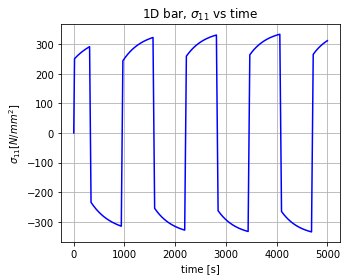

In [12]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(T, store_values[:,0], color = 'blue')

ax.set_title(r'1D bar, $\sigma_{11}$ vs time')
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\sigma_{11} [N/mm^2]$')
ax.grid()

# plt.savefig('stress_vs_time.jpeg', bbox_inches = "tight", dpi = 300)

plt.show()

# Strain vs time

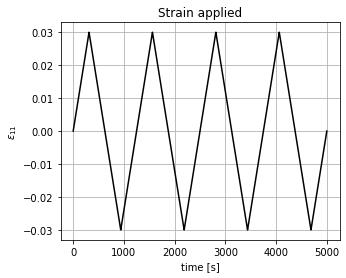

In [13]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(T, strain_linspace, color = 'black')

ax.set_title(r'Strain applied')
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\varepsilon_{11}$')
ax.grid()

# plt.savefig('strain_vs_time.jpeg', bbox_inches = "tight", dpi = 300)

plt.show()

# Stress vs Strain

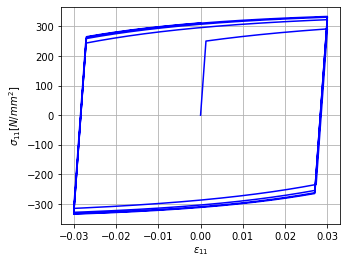

In [14]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(strain_linspace, store_values[:,0], color = 'blue')

ax.set_xlabel(r'$\varepsilon_{11}$')
ax.set_ylabel(r'$\sigma_{11} [N/mm^2]$')
ax.grid()

# plt.savefig('stress_vs_strain.jpeg', bbox_inches = "tight", dpi = 300)

plt.show()

# Isotropic and Kinematic Hardening

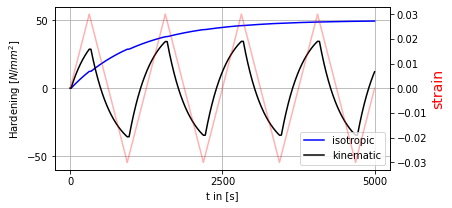

In [15]:
fig, ax = plt.subplots(figsize=(6,3))

ax.plot(T, store_values[:,1], color = 'blue', label = 'isotropic')
ax.plot(T, store_values[:,2], color = 'black', label = 'kinematic')

# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(T, strain_linspace, color="red", alpha = 0.3)
ax2.set_ylabel("strain", color="red", fontsize=14)

ax.set_ylabel(r'Hardening $[N/mm^2]$')
ax.set_xlabel('t in [s]')
ax.set_ylim(-60,60)
ax.set_yticks([-50,0,50])
ax.set_xticks([0, 2500, 5000])
ax.legend(loc = 'lower right')
ax.grid()

# plt.savefig('hardening_vs_time.jpeg', bbox_inches = "tight", dpi = 300)

plt.show()

# Lower resolution

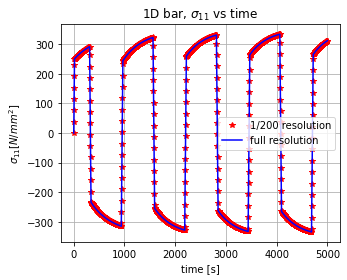

In [16]:
delta_t1 = 2
q = int(delta_t1/delta_t)
N1 = int((t_max-t_min)/delta_t1)
T1 = np.linspace(t_min,t_max,N1+1)

store_values1 = np.copy(store_values)

# return lower resolution result
store_values1 = store_values1[::q]

fig, ax = plt.subplots(figsize=(5,4))

ax.plot(T1, store_values1[:,0], '*', color = 'red', label = '1/200 resolution')
ax.plot(T, store_values[:,0], color = 'blue', label = 'full resolution')

ax.set_title(r'1D bar, $\sigma_{11}$ vs time')
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\sigma_{11} [N/mm^2]$')
ax.legend()
ax.grid()

plt.show()
